# Recomendador de Musica utilizando Spotify

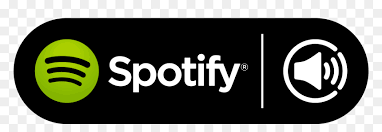

**Objetivo**
El objetivo de esta libreta es realizar un Motor de Recomendación de Canciones utilizando una base de datos pequeña de Spotify y el algoritmo K-Medias.

## Librerías

#### Instalar las librerías

Las librerías necesarias para la ejecución de esta libreta se encuentran en el archivo ``requeriments.txt``.

In [1]:
!pip install -r requirements.txt

You should consider upgrading via the 'C:\virtual_env\Sonia\SoniaM\Scripts\python.exe -m pip install --upgrade pip' command.


#### Importar las librerías

1. Librerías para la manipulación de datos
2. Spotify
3. Configuración del sistema
4. Inteligencia Artificial
5. Big Data (Spark)

In [2]:
# Manipulación de datos ═══════════════════════════════════════════
import numpy as np
import pandas as pd
from collections import defaultdict

# Spotify ═════════════════════════════════════════════════════════
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Configuración del sistema ═══════════════════════════════════════
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# Inteligencia Artificial ═════════════════════════════════════════
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist

# Big Data (Spark) ════════════════════════════════════════════════
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.pandas as ps # o pd
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

%matplotlib inline

## Datos

#### Inicializar Spark
Se crea una nueva sesión de Spark llamada *Spotify Recommender*.

In [3]:
spark = SparkSession.builder.appName('Spotify Recommender').getOrCreate()

#### Cargar los datos

Se cargan los datos desde un archivo `csv`.

In [4]:
data = spark.read.csv('data/data.csv', sep=',', inferSchema=True, header=True)

#### Información de los datos

**Estructura**

In [5]:
print(data.printSchema())

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- key: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- tempo: string (nullable = true)

None


**Información**

In [6]:
print(data.show(10))

+------------------+----+------------+--------------------+------------------+-----------+-------------------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+-----------------+
|           valence|year|acousticness|             artists|      danceability|duration_ms|             energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|                name|popularity|release_date|speechiness|            tempo|
+------------------+----+------------+--------------------+------------------+-----------+-------------------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+-----------------+
|            0.0594|1921|       0.982|['Sergei Rachmani...|             0.279|     831667|              0.211|       0|4BJqT0PrAfrxzMOxy...|           0.878| 10|   0.665|            -20.0

In [7]:
data.select('duration_ms','explicit','energy','popularity','danceability','instrumentalness','liveness','loudness').show(10)

+-----------+--------+-------------------+----------+------------------+----------------+--------+-------------------+
|duration_ms|explicit|             energy|popularity|      danceability|instrumentalness|liveness|           loudness|
+-----------+--------+-------------------+----------+------------------+----------------+--------+-------------------+
|     831667|       0|              0.211|         4|             0.279|           0.878|   0.665|            -20.096|
|     180533|       0|              0.341|         5|0.8190000000000001|             0.0|    0.16|            -12.441|
|     500062|       0|              0.166|         5|             0.328|           0.913|   0.101|             -14.85|
|     210000|       0|              0.309|         3|             0.275|        2.77e-05|   0.381|             -9.316|
|     166693|       0|              0.193|         2|             0.418|        1.68e-06|   0.229|            -10.096|
|     395076|       0|0.34600000000000003|      

**Datos faltantes**

In [8]:
# Conversión de tipos.
data = data.withColumn("duration_ms"     ,col("duration_ms")     .cast("double"))
data = data.withColumn("explicit"        ,col("explicit")        .cast("double"))
data = data.withColumn("energy"          ,col("energy")          .cast("double"))
data = data.withColumn("popularity"      ,col("popularity")      .cast("double"))
data = data.withColumn("danceability"    ,col("danceability")    .cast("double"))
data = data.withColumn("instrumentalness",col("instrumentalness").cast("double"))
data = data.withColumn("liveness"        ,col("liveness")        .cast("double"))
data = data.withColumn("loudness"        ,col("loudness")        .cast("double"))

# Conteo de datos faltantes o datos basura.
data = data.na.fill(value=0)
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+
|valence|year|acousticness|artists|danceability|duration_ms|energy|explicit| id|instrumentalness|key|liveness|loudness|mode|name|popularity|release_date|speechiness|tempo|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+
|      0|   0|           0|      0|           0|          0|     0|       0|  0|               0|  0|       0|       0|   0|   0|         0|           0|          0|    0|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+



## Implementación del algoritmo K-Medias (*K-Means*)

![K-Means](Imagenes/kmeans.png)

El objetivo principal del método es agrupar las observaciones en grupos lo más semejante entre sí y que las pertenecientes a grupos distintos sean lo más desemejante entre sí. Las medias como la euclídea son utilizadas para medir la semejanza y desemejanza.

Entre sus características podemos encontrar:
- El método K-Medias divide un conjunto de $n$ observaciones en $k$ grupos.
- Cada grupo es representado por el promedio de los puntos que lo componen.
- El representante de cada grupo se denomina centroide.
- La cantidad de grupos $k$, es parámetro que se debe establecer.

#### Implementación

In [9]:
featuresUsed = ['duration_ms','explicit','energy','popularity','danceability','instrumentalness','liveness','loudness','year']
assembler = VectorAssembler(inputCols=featuresUsed,outputCol='features_unscaled')
assembled = assembler.transform(data)

In [10]:
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features_unscaled', metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,12):
    KMeans_=KMeans(featuresCol='features_unscaled', k=K)
    KMeans_fit=KMeans_.fit(assembled)
    output_df=KMeans_fit.transform(assembled)
    evaluation_score=evaluator.evaluate(output_df)
    silhouette_scores.append(evaluation_score)

#### Número de clusters.

Text(0, 0.5, 'Silhouette Score')

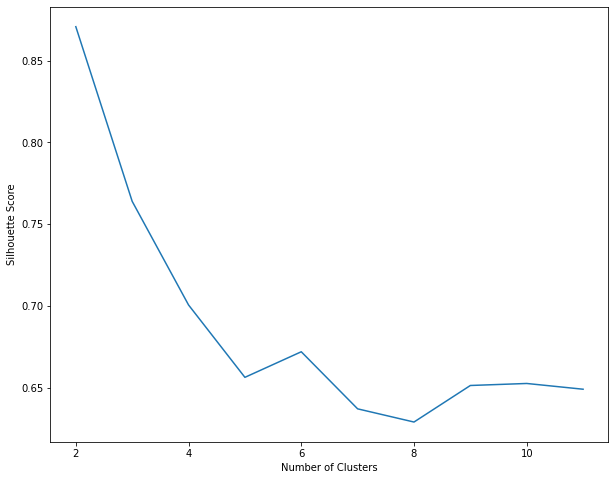

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,12),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [12]:
output_df.select('name','year','prediction').show(10)

+--------------------+----+----------+
|                name|year|prediction|
+--------------------+----+----------+
|Piano Concerto No...|1921|         6|
|Clancy Lowered th...|1921|         9|
|           Gati Bali|1921|         1|
|           Danny Boy|1921|         0|
|When Irish Eyes A...|1921|         9|
|        Gati Mardika|1921|        10|
|The Wearing of th...|1921|         9|
|Morceaux de fanta...|1921|         0|
|La Mañanita - Rem...|1921|         9|
|   Il Etait Syndiqué|1921|         9|
+--------------------+----+----------+
only showing top 10 rows



In [13]:
psdf = output_df.toPandas()

In [14]:
psdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   valence            170653 non-null  float64
 1   year               170653 non-null  int32  
 2   acousticness       170653 non-null  float64
 3   artists            170653 non-null  object 
 4   danceability       170653 non-null  float64
 5   duration_ms        170653 non-null  float64
 6   energy             170653 non-null  float64
 7   explicit           170653 non-null  float64
 8   id                 170653 non-null  object 
 9   instrumentalness   170653 non-null  float64
 10  key                170653 non-null  object 
 11  liveness           170653 non-null  float64
 12  loudness           170653 non-null  float64
 13  mode               170653 non-null  object 
 14  name               170653 non-null  object 
 15  popularity         170653 non-null  float64
 16  re

## Motor de recomendación

Los análisis y las visualizaciones siguieren que los géneros similares tienden ubicarse cerca al igual que las canciones por tipos; esto tiene sentido, los géneros similares suelen tener un ritmo y tempo similar.

Teniendo en cuenta lo anterior es posible construir un sistema de recomendación tomando los puntos de los datos de las canciones que el usuario está escuchando y recomendar canciones que se encuentren cercanas es decir, que correspondan a los datos cercanos. [Spotipy](https://spotipy.readthedocs.io/en/2.16.1/) es un cliente de Python para la API web de Spotify que facilita a los desarrolladores la obtención de datos y la consulta de canciones en el catálogo de Spotify (`pip install spotipy`). También es necesario crear una aplicación en la [página del desarrollador de Spotify] (https://developer.spotify.com/) y guardar su ID de cliente y clave secreta para acceder a la API.

#### Definición del pipeline

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=20, 
                                   verbose=False))
                                 ], verbose=False)

#### Funciones auxiliares para la búsqueda y manipulación de los datos de las canciones

In [16]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="62cfe79d83ef43c69a7ba63f9f5debda",
                                                           client_secret="88e6707695634f04a75301fcc77d7789"))

def find_song(name, year):
    """

    Args:
        name: nombre de la canción
        year: año de publicación de la canción

    Returns: dataframe con la información de la canción obtenida de la API de Spotify.

    """
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if not results['tracks']['items']:
        return None
    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)

In [17]:
featuresUsed = ['duration_ms','explicit','energy','popularity','danceability','instrumentalness','liveness','loudness','year']


def get_song_data(song, spotify_data):
    """

    Args:
        song: información de la canción
        spotify_data: información de spotify (dataset)

    Returns: dataframe con la información de la canción solicitada.

    """

    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) 
                                & (spotify_data['year'] == song['year'])].iloc[0]
        
        return song_data
    
    except IndexError:
        return find_song(song['name'], song['year'])
        

def get_mean_vector(song_list, spotify_data):
    """

    Args:
        song_list: lista de canciones
        spotify_data: información de spotify (dataset)

    Returns: La canción representante del grupo según la lsita de canciones.

    """
    song_vectors = []
    
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[featuresUsed].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):
    """

    Args:
        dict_list: diccionario con las canciones y sus años

    Returns: diccionario con las canciones (keys) y sus años (value list)

    """
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict


def recommend_songs(song_list, spotify_data, n_songs=5):
    """

    Args:
        song_list: lista de canciones del usuario
        spotify_data: información de Spotify (dataset)
        n_songs: número de canciones

    Returns: las n_songs semejantes a las canciones dadas como entrada

    """
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    X = psdf[featuresUsed]
    number_cols = list(X.columns)
    song_cluster_pipeline.fit(X)
    song_cluster_labels = song_cluster_pipeline.predict(X)
    psdf['cluster_label'] = song_cluster_labels
    scaled_data = scaler.transform(spotify_data[featuresUsed])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')


#### Prueba #1

In [18]:
recommend_songs([{'name': 'The Trooper',     'year': 1991},
                 {'name': 'Strutter',        'year': 1974},
                 {'name': 'Lithium',         'year': 1992},
                 {'name': 'All Apologies',   'year': 1993},
                 {'name': 'Numb',            'year': 2002}],  psdf)

[{'name': 'El Perdón',
  'year': 2017,
  'artists': "['Nicky Jam', 'Enrique Iglesias']"},
 {'name': 'Come & Go (with Marshmello)',
  'year': 2020,
  'artists': "['Juice WRLD', 'Marshmello']"},
 {'name': 'El Güero (Feat. Marca MP)',
  'year': 2019,
  'artists': "['Grupo Firme', 'Marca MP']"},
 {'name': 'Fast', 'year': 2019, 'artists': "['Juice WRLD']"},
 {'name': 'Cold Little Heart - Radio Edit',
  'year': 2017,
  'artists': "['Michael Kiwanuka']"}]

#### Prueba #2

In [19]:
recommend_songs([{'name': 'Come As You Are',         'year': 1991},
                 {'name': 'Smells Like Teen Spirit', 'year': 1991},
                 {'name': 'Lithium',                 'year': 1992},
                 {'name': 'All Apologies',           'year': 1993},
                 {'name': 'Stay Away',               'year': 1993}],  psdf)

[{'name': 'Strawberry Wine', 'year': 1996, 'artists': "['Deana Carter']"},
 {'name': 'Coleccionista de Canciones', 'year': 2006, 'artists': "['Camila']"},
 {'name': 'Yo Te Amo', 'year': 2000, 'artists': "['Chayanne']"},
 {'name': 'All I Really Want - 2015 Remaster',
  'year': 1995,
  'artists': "['Alanis Morissette']"},
 {'name': 'Sweet Lady', 'year': 1998, 'artists': "['Tyrese']"}]

En esta última celda se obtiene la lista de canciones recomendadas.